# Import base libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


# Read Dota2 match data from csv file

In [37]:
doto_match_df = pd.read_csv("./data.csv")
doto_match_df.head()

,camps_stacked,denies,last_hits,assists,deaths,kills,match_id,start_time,win,hero_id,account_id,leaguename
0,33,4,56,21,5,2,5465684523,1591890200,True,90,326177197,GamaGames - Season 4 Professional - Part 2
1,32,0,61,11,8,0,5341713652,1586337968,False,90,319405932,Masters Tournament
2,32,0,25,19,2,0,3276678806,1498544603,True,30,86772934,The International 2017
3,31,2,101,19,4,0,5250431775,1582116657,False,90,1058332010,Asia Challenger league
4,29,0,69,17,7,2,4777319992,1558620545,False,75,186575040,TNG League 1


# Check the win rate  
You can see data is not biased to win or lose

In [38]:
doto_match_df.groupby('win').size()

win
False     93642
True     106358
dtype: int64

# Reorder data & delete useless column  
start_time is not related to win,league name and account_id is limited, result in worse performance

In [39]:
doto_match_df = doto_match_df[['match_id', 'win', 'kills', 'deaths', 'assists', 'last_hits', 'denies', 'camps_stacked', 'hero_id']]
doto_match_df.head()

,match_id,win,kills,deaths,assists,last_hits,denies,camps_stacked,hero_id
0,5465684523,True,2,5,21,56,4,33,90
1,5341713652,False,0,8,11,61,0,32,90
2,3276678806,True,0,2,19,25,0,32,30
3,5250431775,False,0,4,19,101,2,31,90
4,4777319992,False,2,7,17,69,0,29,75


In [40]:
print(doto_match_df.hero_id.min())
print(doto_match_df.hero_id.max())

1
129


# one-hot encode hero_id  
As hero_id is index, not numerical value, it has to be encoded

In [41]:
doto_match_df = pd.get_dummies(doto_match_df, columns=['hero_id'])
print(doto_match_df.shape)

(200000, 127)


# Split data using match_id  
since match_id is independent to win, use it to split and drop it

In [42]:
doto_match_train = doto_match_df[doto_match_df.match_id % 10 < 7]
doto_match_test = doto_match_df[doto_match_df.match_id % 10 >= 7]
doto_match_train = doto_match_train.drop('match_id', axis=1)
doto_match_test = doto_match_test.drop('match_id', axis=1)
print(doto_match_train.shape, doto_match_test.shape)

(139242, 126) (60758, 126)


In [43]:
doto_match_train.head()

,win,kills,deaths,assists,last_hits,denies,camps_stacked,hero_id_1,hero_id_2,hero_id_3,...,hero_id_111,hero_id_112,hero_id_113,hero_id_114,hero_id_119,hero_id_120,hero_id_121,hero_id_126,hero_id_128,hero_id_129
0,True,2,5,21,56,4,33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,0,8,11,61,0,32,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,0,2,19,25,0,32,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,0,4,19,101,2,31,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,2,7,17,69,0,29,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
doto_match_test.head()

,win,kills,deaths,assists,last_hits,denies,camps_stacked,hero_id_1,hero_id_2,hero_id_3,...,hero_id_111,hero_id_112,hero_id_113,hero_id_114,hero_id_119,hero_id_120,hero_id_121,hero_id_126,hero_id_128,hero_id_129
10,True,1,13,11,43,1,24,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,False,1,5,5,154,2,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,False,1,6,9,45,1,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,True,2,9,16,30,0,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,True,1,5,13,45,3,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Make custom dataset and dataloader

In [45]:
class DotoDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.len = df.shape[0]
        self.y_data = torch.from_numpy(df['win'].values).float()
        self.y_data = torch.reshape(self.y_data, (-1, 1))
        self.x_data = torch.from_numpy(df.drop('win', axis=1).values).float()
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [46]:
trainset = DotoDataset(doto_match_train)
testset = DotoDataset(doto_match_test)

In [47]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=0)


# Make neural network class  
Make neural network class using pytorch. input size, width of each layer, output size can be varied.

In [48]:
class DotoNet(torch.nn.Module):
    def __init__(self, input_size, width_1, width_2, output_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, width_1)
        self.linear2 = torch.nn.Linear(width_1, width_2)
        self.linear3 = torch.nn.Linear(width_2, output_size)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        return x


# Check GPU works

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Construct model, loss, optimizer

In [50]:
# Construct model for doto
model = DotoNet(125, 256, 64, 1).to(device=device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3.3e-6, momentum=0.9)
    

# Make function for accuracy

In [63]:
def accuracy_checker():
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for data in trainloader:
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(inputs)
            predicted = outputs.data>=0.5
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    accuracy_train = correct_train / total_train
    print('Accuracy of the network on the trainset: %d %%' % (
        100 * accuracy_train))
    print(correct_train, total_train)

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(inputs)
            predicted = outputs.data>=0.5
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    accuracy_test = correct_test / total_test
    print('Accuracy of the network on the testset: %d %%' % (
        100 * accuracy_test))
    print(correct_test, total_test)

    return accuracy_train, accuracy_test



# Start training

In [52]:
loss_list = []
accuracy_list =[]
for epoch in range(150):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list.append(running_loss / 2000)
            running_loss = 0.0
        if epoch % 10 ==9 and i==0:
            accuracy_list.append(accuracy_checker())
            
print('Finished Training')

[1,  2000] loss: 0.700
[1,  4000] loss: 0.697
[2,  2000] loss: 0.696
[2,  4000] loss: 0.695
[3,  2000] loss: 0.695
[3,  4000] loss: 0.695
[4,  2000] loss: 0.694
[4,  4000] loss: 0.694
[5,  2000] loss: 0.694
[5,  4000] loss: 0.693
[6,  2000] loss: 0.693
[6,  4000] loss: 0.693
[7,  2000] loss: 0.693
[7,  4000] loss: 0.692
[8,  2000] loss: 0.693
[8,  4000] loss: 0.692
[9,  2000] loss: 0.692
[9,  4000] loss: 0.692
Accuracy of the network on the trainset: 47 %
65507 139242
Accuracy of the network on the testset: 46 %
60758 60758
[10,  2000] loss: 0.692
[10,  4000] loss: 0.692
[11,  2000] loss: 0.691
[11,  4000] loss: 0.691
[12,  2000] loss: 0.690
[12,  4000] loss: 0.691
[13,  2000] loss: 0.690
[13,  4000] loss: 0.690
[14,  2000] loss: 0.689
[14,  4000] loss: 0.689
[15,  2000] loss: 0.688
[15,  4000] loss: 0.688
[16,  2000] loss: 0.687
[16,  4000] loss: 0.686
[17,  2000] loss: 0.686
[17,  4000] loss: 0.684
[18,  2000] loss: 0.684
[18,  4000] loss: 0.683
[19,  2000] loss: 0.682
[19,  4000] lo

In [65]:
accuracy_checker()

Accuracy of the network on the trainset: 83 %
116214 139242
Accuracy of the network on the testset: 83 %
50709 60758


(0.83461886499763, 0.8346061424010007)

# Learning curve, accuracy curve

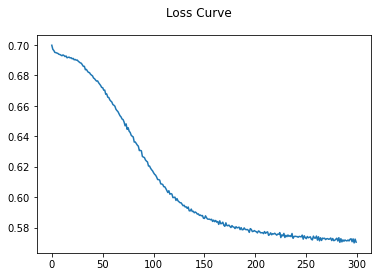

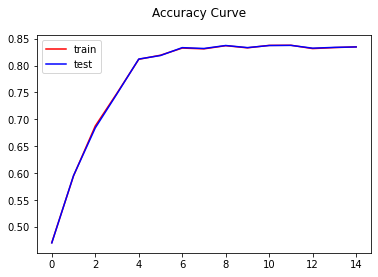

In [61]:
fig1, ax1 = plt.subplots()
ax1.plot(loss_list)
fig1.suptitle('Loss Curve')
fig2, ax2= plt.subplots()
accuracy_list = np.array(accuracy_list)
ax2.plot(accuracy_list[:,0], label='train', c='r')
ax2.plot(accuracy_list[:,1], label='test', c='b')
ax2.legend(loc='best')
fig2.suptitle("Accuracy Curve")
plt.show()